<a href="https://colab.research.google.com/github/vmpreciado/DS4CN/blob/main/Intro2NetworkX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! This notebook is a **self-contained introduction** to **NetworkX**, a Python library for creating and analyzing graphs (networks).

### Learning goals
By the end of this notebook, you should be able to:
- create **undirected** and **directed** graphs in NetworkX,
- visualize graphs using common layouts,
- understand the three standard graph representations:
  **list of edges (LoE)**, **adjacency list (AL)**, and **adjacency matrix (AM)**,
- work with a classic real network dataset (Zachary's Karate Club),
- understand what a **tree** is and visualize it as a rooted structure.

### How to use this notebook
For self-study, read the **markdown explanations** and run the code cells **in order**.  
Feel free to modify parameters (e.g., layouts, seeds) and re-run to build intuition.


In [1]:
# Install dependencies if needed (safe to re-run)
import importlib, sys, subprocess

def ensure_package(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ["networkx", "matplotlib", "numpy"]:
    ensure_package(pkg)


In this section, we dive into the practical aspects of using **NetworkX**.
We will build intuition by working with concrete examples and progressively
introducing more advanced graph concepts.

In [2]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Reproducibility (affects random layouts, random choices, etc.)
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

def draw_graph(G, title="", pos=None, with_labels=True, node_size=600):
    """Draw a graph with a consistent spring layout (unless pos is provided)."""
    if pos is None:
        pos = nx.spring_layout(G, seed=SEED)
    plt.figure(figsize=(5,4))
    nx.draw(G, pos=pos, with_labels=with_labels, node_size=node_size, arrows=G.is_directed())
    plt.title(title)
    plt.axis("off")
    return pos

# Create a small undirected graph and add one edge
G = nx.Graph()
G.add_edge("1", "2")  # nodes can be strings, integers, etc.

print("Nodes:", list(G.nodes()))
print("Edges:", list(G.edges()))


Nodes: ['1', '2']
Edges: [('1', '2')]


Let's expand our graph by adding more edges. By doing so, we can observe how the graph evolves with each addition, providing us with insight into the dynamic nature of network connections.

In [3]:
# Add more edges (including a self-loop at node "1")
G.add_edges_from([("2", "3"), ("3", "4"), ("4", "1"), ("1", "1")])

print("Nodes:", list(G.nodes()))
print("Edges:", list(G.edges()))


Nodes: ['1', '2', '3', '4']
Edges: [('1', '2'), ('1', '4'), ('1', '1'), ('2', '3'), ('3', '4')]


Visual representation is key to understanding network structures. Let's render our graph 'G' using NetworkX's visualization capabilities to get a clearer picture of its structure.

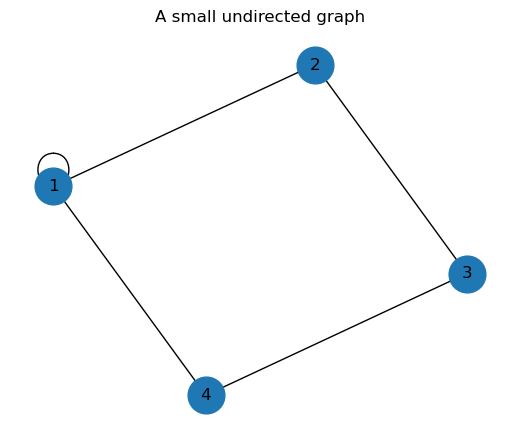

In [4]:
# Visualize the small graph
_ = draw_graph(G, title="A small undirected graph", with_labels=True, node_size=700)
plt.show()


As a second example, we generate and visualize a **tree** graph. Trees satisfy the following properties:

- a tree is **connected**, and
- **acyclic** (it contains no cycles).

Equivalent characterizations of a tree graph are:
- a connected graph with $n$ nodes has exactly $n-1$ edges, or
- there is a **unique path** between any pair of nodes in the graph.

In many applications we pick a particular node of the tree to be the **root** and view the tree as a hierarchical structure, as follows:
nodes at distance $0$ are at the top (the root), then distance $1,2,\ldots$ appear on lower levels. We visualize this structure at the end of the next code cell.


Tree summary:
  Nodes: 31
  Edges: 30 (should be n-1)
  Connected: True
  Acyclic (is_tree): True


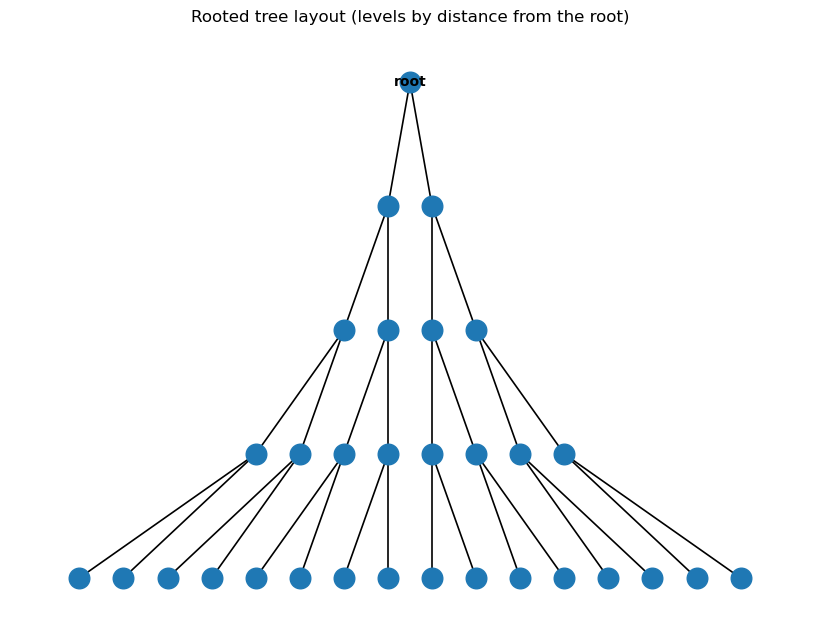

In [18]:
# ----------------------------
# Generate and visualize a rooted tree
# ----------------------------
from collections import defaultdict

# Example: a balanced binary tree of height 4 (levels 0..4)
T = nx.balanced_tree(r=2, h=4)  # undirected tree
root = 0

print("Tree summary:")
print("  Nodes:", T.number_of_nodes())
print("  Edges:", T.number_of_edges(), "(should be n-1)")
print("  Connected:", nx.is_connected(T))
print("  Acyclic (is_tree):", nx.is_tree(T))

# BFS distances from the root define the levels
dist = dict(nx.single_source_shortest_path_length(T, root))
max_level = max(dist.values())

levels = {d: [] for d in range(max_level + 1)}
for v, d in dist.items():
    levels[d].append(v)
for d in levels:
    levels[d] = sorted(levels[d])

# Parent map from BFS tree (keeps siblings together in the drawing)
parent = {root: None}
for u, v in nx.bfs_tree(T, root).edges():
    parent[v] = u

# Order nodes per level by parent order
order = {0: [root]}
for d in range(1, max_level + 1):
    children_by_parent = defaultdict(list)
    for v in levels[d]:
        children_by_parent[parent[v]].append(v)
    for p in children_by_parent:
        children_by_parent[p] = sorted(children_by_parent[p])
    flat = []
    for p in order[d - 1]:
        flat.extend(children_by_parent.get(p, []))
    order[d] = flat

# Assign positions: y = -level, x spreads nodes within a level
pos_tree = {}
y_gap = 1.6
x_gap = 1.0

for d in range(max_level + 1):
    nodes_d = order[d]
    k = len(nodes_d)
    if k == 0:
        continue
    x0 = -(k - 1) / 2.0
    for j, v in enumerate(nodes_d):
        pos_tree[v] = ((x0 + j) * x_gap, -d * y_gap)

plt.figure(figsize=(8, 6))
nx.draw(T, pos=pos_tree, with_labels=False, node_size=220, width=1.2)
nx.draw_networkx_labels(T, pos=pos_tree, labels={root: "root"}, font_size=10, font_weight="bold")
plt.title("Rooted tree layout (levels by distance from the root)")
plt.axis("off")
plt.show()


NetworkX includes several **built-in datasets**. A classic example is **Zachary's Karate Club graph** (1977),
an undirected social network where nodes represent club members and edges represent friendships.

We will load this graph and visualize it using several common layouts.

In [6]:
# Load the Zachary's Karate Club graph from the NetworkX library of preloaded graph
G = nx.karate_club_graph()

First, let's visualize the Zachary graph using a random layout. This approach places nodes randomly, offering a unique and sometimes chaotic view of the network's structure.

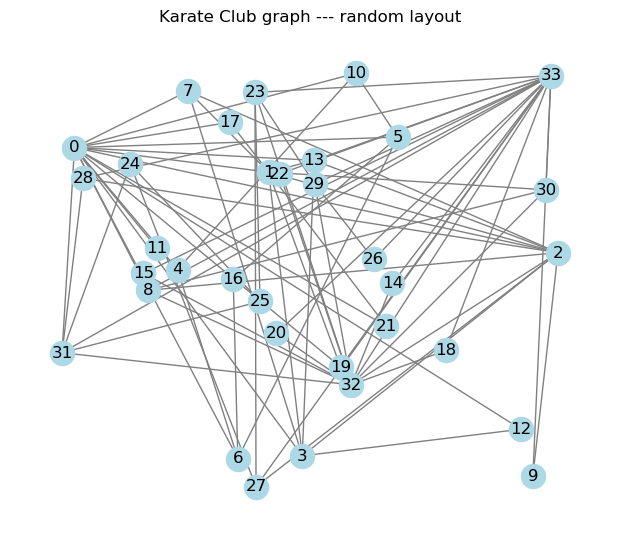

In [7]:
# Random layout (positions are random)
pos = nx.random_layout(G, seed=SEED)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
plt.title("Karate Club graph --- random layout")
plt.axis("off")
plt.show()


Another interesting visualization is the circular layout, which arranges the nodes in a circle. This layout can help us observe patterns and clusters within the network that might not be apparent in other layouts.

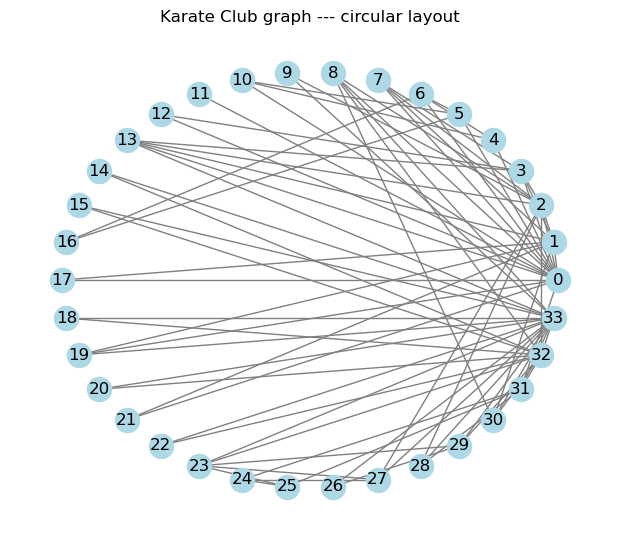

In [8]:
# Circular layout (nodes arranged on a circle)
pos = nx.circular_layout(G)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
plt.title("Karate Club graph --- circular layout")
plt.axis("off")
plt.show()


The spectral layout uses eigenvectors of the graph's Laplacian matrix to position the nodes (to be covered later in the course). It's particularly useful for highlighting the graph's community structure and other underlying patterns.

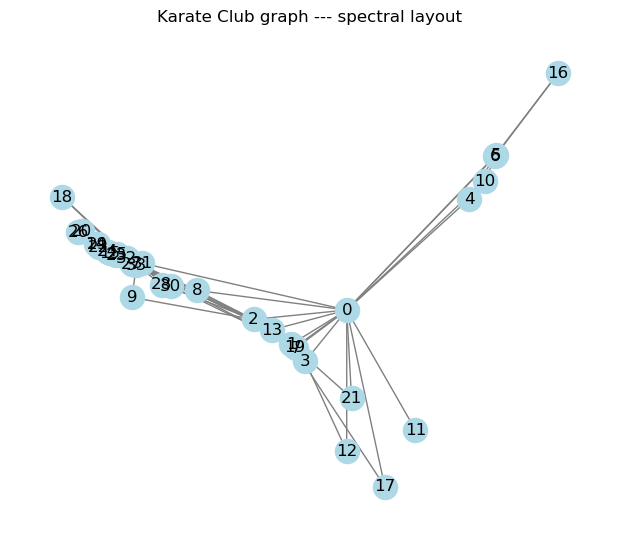

In [9]:
# Spectral layout (based on eigenvectors of a graph matrix)
pos = nx.spectral_layout(G)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
plt.title("Karate Club graph --- spectral layout")
plt.axis("off")
plt.show()


Finally, we'll employ the spring layout, which positions nodes using a force-directed approach, simulating attractive and repulsive forces among them. This layout often results in aesthetically pleasing and intuitively understandable representations of networks.

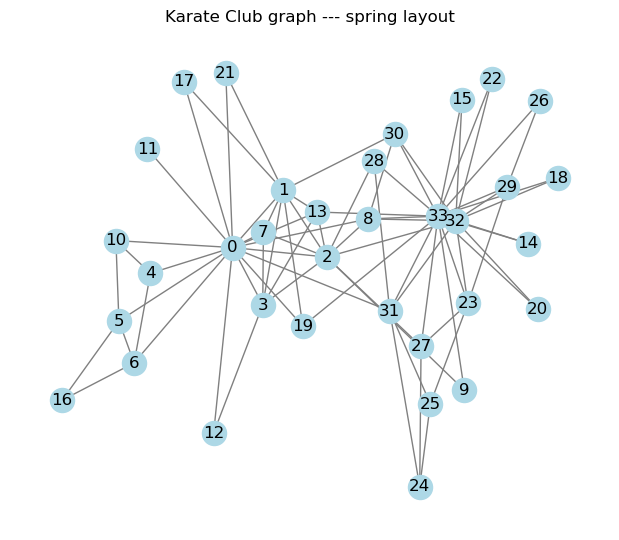

In [10]:
# Spring layout (force-directed; often produces readable drawings)
pos = nx.spring_layout(G, seed=SEED)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300)
plt.title("Karate Club graph --- spring layout")
plt.axis("off")
plt.show()


Now we introduce three standard ways to represent a graph in memory:

- **List of edges (LoE)**: store each edge once as a pair (u,v).
- **Adjacency list (AL)**: for each node, store a list of its neighbors.
- **Adjacency matrix (AM)**: a matrix A where A[i,j]=1 if there is an edge (i,j).

These representations have different memory costs and support different algorithms efficiently.


In [11]:
# List of edges (LoE)
edges = list(G.edges())
print("Number of edges:", len(edges))
print("First 15 edges:", edges[:15])


Number of edges: 78
First 15 edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21)]


In the Karate Club graph, nodes are labeled by integers (0,1,2,...).
This is convenient for adjacency matrices, where rows/columns correspond to node indices.


The **adjacency list** is typically the most efficient representation for sparse graphs.
Many traversal algorithms (BFS/DFS) rely on quickly enumerating neighbors of a node.


In [12]:
# Adjacency list (AL) as a dictionary: node -> sorted list of neighbors
adjacency_list = {u: sorted(list(G.neighbors(u))) for u in G.nodes()}

target_node = 0
print(f"Neighbors of node {target_node}:", adjacency_list[target_node])


Neighbors of node 0: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


To inspect the full adjacency list, we can iterate over the dictionary.
(We print only a few lines above to keep output readable.)

In [13]:
# Print the adjacency list for the first few nodes
for node in sorted(list(adjacency_list.keys()))[:10]:
    print(f"{node}: {adjacency_list[node]}")


0: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]
1: [0, 2, 3, 7, 13, 17, 19, 21, 30]
2: [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
3: [0, 1, 2, 7, 12, 13]
4: [0, 6, 10]
5: [0, 6, 10, 16]
6: [0, 4, 5, 16]
7: [0, 1, 2, 3]
8: [0, 2, 30, 32, 33]
9: [2, 33]


The **adjacency matrix** stores connectivity in an n×n matrix.
For sparse graphs, most entries are zero. A useful visualization is a **spy plot**,
which shows the locations of nonzero entries.

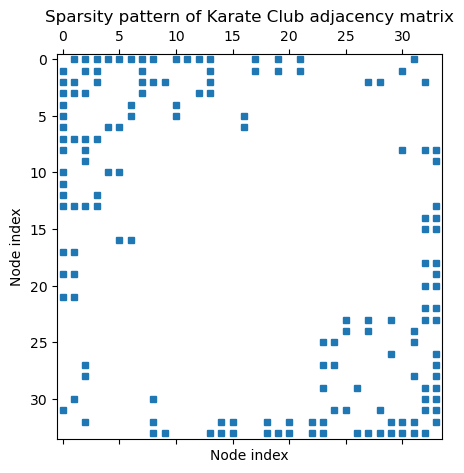

In [14]:
import numpy as np

# Adjacency matrix as a SciPy sparse matrix (efficient for large sparse graphs)
adj_matrix_sparse = nx.adjacency_matrix(G)

# Spy plot: visualize the sparsity pattern
plt.figure(figsize=(5,5))
plt.spy(adj_matrix_sparse, markersize=5)
plt.title("Sparsity pattern of Karate Club adjacency matrix")
plt.xlabel("Node index")
plt.ylabel("Node index")
plt.show()


The matrix is symmetric because the Karate Club graph is undirected:
if (i,j) is an edge, then (j,i) is also an edge.


NetworkX also supports **directed graphs** (digraphs), where edges have a direction (u→v).
Directed graphs are useful for modeling hyperlinks, follower graphs, citation networks, etc.


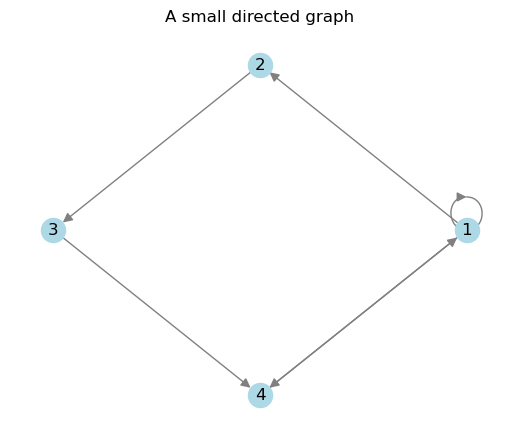

In [15]:
# Create a small directed graph
D = nx.DiGraph()
D.add_nodes_from([1, 2, 3, 4])
D.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1), (1, 4), (1, 1)])  # includes a self-loop

posD = nx.circular_layout(D)
plt.figure(figsize=(5,4))
nx.draw(D, posD, with_labels=True, node_color="lightblue", edge_color="gray", arrows=True, arrowsize=14)
plt.title("A small directed graph")
plt.axis("off")
plt.show()


Many networks have **weighted edges**, representing strength, cost, delay, capacity, etc.
Below we assign random integer weights to each directed edge and display them.

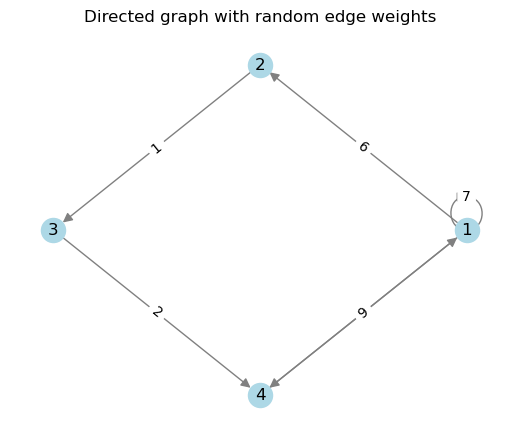

In [16]:
import random
random.seed(SEED)

# Assign a random weight between 1 and 10 to each edge
for (u, v) in D.edges():
    D[u][v]["weight"] = random.randint(1, 10)

pos = nx.circular_layout(D)
plt.figure(figsize=(5,4))
nx.draw(D, pos, with_labels=True, node_color="lightblue", edge_color="gray", arrows=True, arrowsize=14)

edge_labels = nx.get_edge_attributes(D, "weight")
nx.draw_networkx_edge_labels(D, pos, edge_labels=edge_labels, font_size=10)
plt.title("Directed graph with random edge weights")
plt.axis("off")
plt.show()
